<a href="https://colab.research.google.com/github/cyrilgabriele/RL/blob/main/Lab04/Lab_04_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%matplotlib inline
from typing import Tuple, List

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Q-Learning on the CartPole Environment

This is an altered version of Jose Nieves Flores Maynez' notebook.

This tutorial shows how to use Q-Learning to train an RL agent on the CartPole-v0 task from the [OpenAI Gym](https://gym.openai.com/).

![cartpole](https://github.com/pytorch/tutorials/blob/main/_static/img/cartpole.gif?raw=true)

The Cartpole environment is a common simple example that is used often for simple RL examples.

In this environment, the task is to balance the pole that is attached to the cart, by moving the cart to either side.
The reward gets incremented for each step (for up to 200 steps) where the pole is not exceeding a set angle and the cart is not touching the sides of the line.
The environment provides four parameters that represent the state of the environment:
Position and velocity of the cart and angle and angular velocity of the pole (see [the documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)).
We will solve this by applying Q-Learning to our RL agent.


### Packages


First, let's import needed packages.

In [14]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Implementation
Since this algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. The CartPole environment gives us the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state. However, all of these are continuous variables. To be able to solve this problem, we need to discretize these states since otherwise, it would take forever to get values for each of the possible combinations of each state, despite them being bounded. The solution is to group several values of each of the variables into the same “bucket” and treat them as similar states. The agent implemented for this problem uses 3, 3, 6, and 6 buckets respectively.

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


finished training!


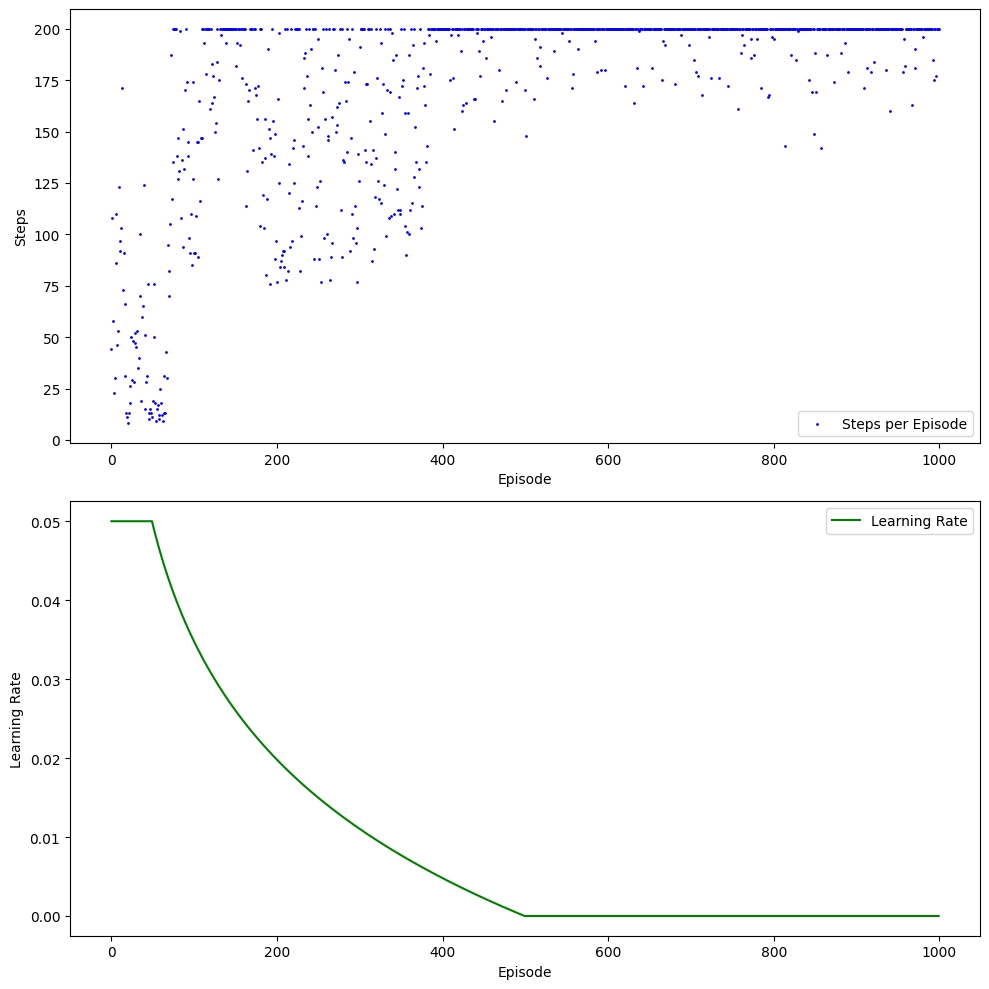

599 episodes were successfully completed.


In [15]:
LEFT = 0
RIGHT = 1

class MonteCarloGeneration(object):
  def __init__(self, env: object, max_steps: int = 1000, debug: bool = False):
    self.env = env
    self.max_steps = max_steps
    self.debug = debug

  def run(self, pi_policy) -> List:
    buffer = []
    n_steps = 0 # Keep track of the number of steps so I can bail out if it takes too long
    state = self.env.reset() # Reset environment back to start
    terminal = False
    while not terminal: # Run until terminal state
      action = self.choose_action(pi_policy, state) # take action based on current policy
      next_state, reward, terminal, _ = self.env.step(action) # Take action in environment
      buffer.append((state, action, reward)) # Store the result
      state = next_state # Ready for the next step
      n_steps += 1
      if n_steps >= self.max_steps:
        if self.debug:
          print("Terminated early due to large number of steps")
        terminal = True # Bail out if we've been working for too long
    return buffer

  def choose_action(self, policy, state):
      prob_left = policy(state)
      if np.random.rand() < prob_left:
        action = LEFT
      else:
        action = RIGHT
      return action


class CartPoleAgent():
    def __init__(self, env: object, generator: MonteCarloGeneration,
                 num_episodes=1000, min_lr=0.00001, discount=1, decay=50, initial_lr=0.05):
        self.num_episodes = num_episodes
        self.min_lr = min_lr # minimal learning rate
        self.initial_lr = initial_lr
        self.discount = discount
        self.decay = decay
        self.generator = generator
        self.env = env

        # Initialize Thetas arbitrarily with random values
        min_value = -1
        max_value = 1
        self.thetas = np.random.uniform(min_value, max_value, size=(1, 4)) #4 = number of states

        self.steps = np.zeros(self.num_episodes)


    def get_learning_rate(self, e):
      # Learning rate declines as we addvance in episodes
      return self.initial_lr * max(self.min_lr, min(1., 1. - math.log10((e + 1) / self.decay)))

    def train(self) -> None:
      for episode_t in range(self.num_episodes):
        trajectory = self.generator.run(self.pi_policy) # Generate a trajectory
        G = 0
        for i, step in enumerate(reversed(trajectory)): # Starting from the terminal state
          self.steps[episode_t] += 1
          state, action, reward = step
          gamma = self.discount**(len(trajectory) - i - 1) # gamma is always 1 (no discounting)
          G += reward * gamma
          learning_rate = self.get_learning_rate(episode_t)
          #update thetas
          self.thetas += learning_rate * gamma * G * self.gradient_pi(state, action)
      print('finished training!')

    def pi_policy(self, state):
        # Given a state, return probability of action left (using logistic function)
        action_left_prob = 1 /  (1 + np.exp(-(np.dot(self.thetas, state))))
        return action_left_prob

    def gradient_pi(self, state, action):
      if (action == LEFT):
        gradient = state - state * self.pi_policy(state)
      else:
        gradient = -state * self.pi_policy(state)
      return gradient

    def plot_learning(self):
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot steps per episode
        ax1.scatter(range(self.num_episodes), self.steps, label='Steps per Episode', color='blue', s=1)
        #für Ardi <3
        #ax1.plot(self.steps, label='Steps per Episode', color='blue')
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Steps")

        # Plot learning rates
        ax2.plot([self.get_learning_rate(e) for e in range(self.num_episodes)], label='Learning Rate', color='green')
        ax2.set_xlabel("Episode")
        ax2.set_ylabel("Learning Rate")

        # Show legends
        ax1.legend()
        ax2.legend()

        # Adjust spacing
        plt.tight_layout()

        # Show the plots
        plt.show()

        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t += 1
        print(t, "episodes were successfully completed.")


def load_REINFORCE():
    env = gym.make('CartPole-v0')
    generator = MonteCarloGeneration(env=env, debug=True)
    agent = CartPoleAgent(env=env, generator=generator)
    agent.train()
    agent.plot_learning()

    return agent

agent = load_REINFORCE()